## Importation des bibliothèques

In [19]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import shap
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Importation de la base de données

In [20]:
# Importation de la base de données
data = pd.read_excel(r"D:\Projects\IT\Data Science & IA\Prediction_des_Maladies_et_Proposition_de_Traitement\datasets\tested_data.xlsx")
print("Base de données importée ✅✅")

Base de données importée ✅✅


## Préparation des données

In [21]:
# Définition des variables
data_exclure = data.drop(columns=['Diagnosis','Treatment'])
x = data_exclure
y = data["Diagnosis"]

## Application de Mutual Information

In [22]:
# Initialisation de Mutual Information
mutual_info = mutual_info_classif(x,y)

# Conversion en dataframe 
mutual = pd.DataFrame({'Feature': x.columns, "MI Scores": mutual_info})

# Tri des scores 
mutual_df = mutual.sort_values(by="MI Scores", ascending=False)

# Filtrage des features avec socre signficatif
mi_selected = mutual_df[mutual_df['MI Scores']>0.01]

# Affichage des résultats
print('Sortie des features pertinentes ✅✅')
print(mi_selected)

Sortie des features pertinentes ✅✅
                  Feature  MI Scores
2           BloodPressure   0.034141
11                Fatigue   0.027033
21                 Fievre   0.025963
23      Perte_gout_odorat   0.022685
13  Respiration sifflante   0.021122
6          FastingGlucose   0.021013
18      Fatigue chronique   0.014960
1                   Pulse   0.012123
19           Vision floue   0.011021


## Application de Random Forest Classifier

In [23]:
# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Modèle de base
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Sélection de features avec RFE
rfe_selector = RFE(model, n_features_to_select=15, step=1)
rfe_selector.fit(X_train, y_train)
rfe_features = X_train.columns[rfe_selector.support_]

print("✅ Features sélectionnées par RFE :", rfe_features)

✅ Features sélectionnées par RFE : Index(['Temperature', 'Pulse', 'BloodPressure', 'SpO2', 'RespiratoryRate',
       'BMI', 'FastingGlucose', 'Cholesterol', 'StressLevel', 'Fievre',
       'Toux_seche', 'Perte_gout_odorat', 'Douleurs_musculaires',
       'Fatigue_intense', 'Frissons'],
      dtype='object')


## Application de SHAP

<Figure size 640x480 with 0 Axes>

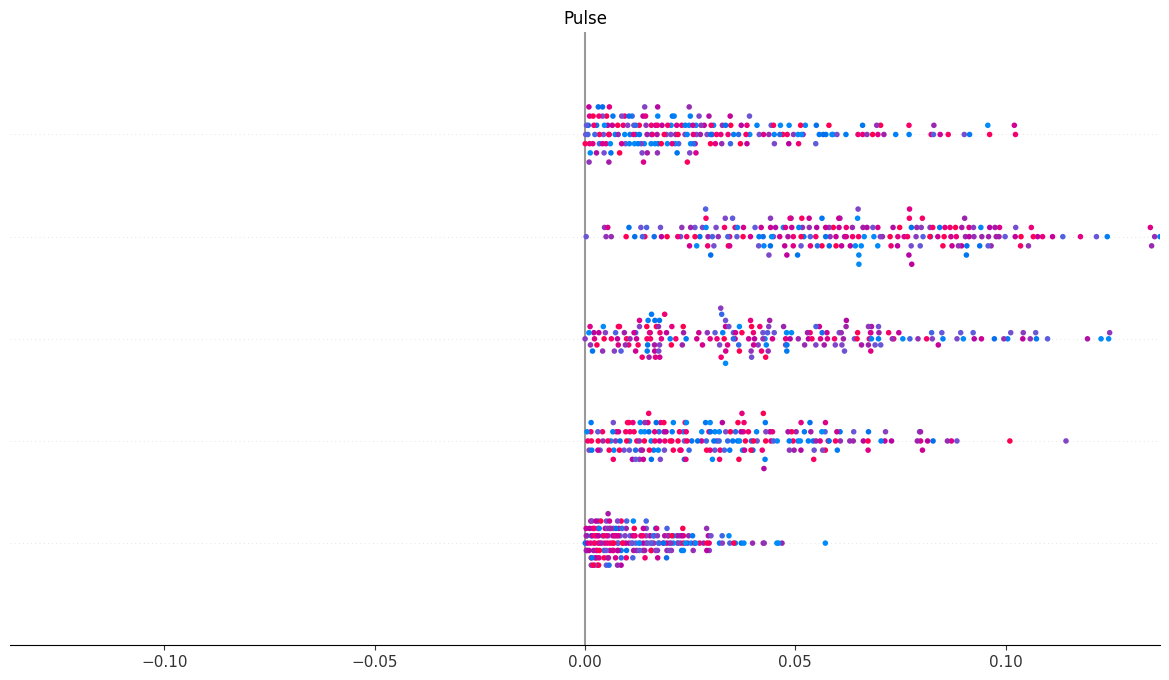


Top features selon SHAP :
[['Pulse' 'Temperature' 'RespiratoryRate' 'SpO2' 'BloodPressure']
 ['BloodPressure' 'Temperature' 'RespiratoryRate' 'SpO2' 'Pulse']
 ['Pulse' 'Temperature' 'BloodPressure' 'SpO2' 'RespiratoryRate']
 ['BloodPressure' 'RespiratoryRate' 'Pulse' 'Temperature' 'SpO2']
 ['Pulse' 'Temperature' 'SpO2' 'RespiratoryRate' 'BloodPressure']
 ['SpO2' 'Pulse' 'RespiratoryRate' 'Temperature' 'BloodPressure']
 ['SpO2' 'RespiratoryRate' 'Temperature' 'BloodPressure' 'Pulse']
 ['SpO2' 'RespiratoryRate' 'Temperature' 'Pulse' 'BloodPressure']
 ['SpO2' 'RespiratoryRate' 'BloodPressure' 'Temperature' 'Pulse']
 ['Temperature' 'Pulse' 'BloodPressure' 'SpO2' 'RespiratoryRate']]


In [24]:
# Analyse SHAP avec TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Gestion des SHAP values (multiclasse ou non)
if isinstance(shap_values, list):
    shap_values_aggregated = np.mean([np.abs(sv) for sv in shap_values], axis=0)
else:
    shap_values_aggregated = np.abs(shap_values)

# Visualisation SHAP
shap.summary_plot(shap_values_aggregated, X_test)

# Conversion explicite des noms de colonnes en array
columns_array = np.array(X_test.columns)
shap_importance = shap_values_aggregated.mean(axis=0)
shap_features = columns_array[np.argsort(-shap_importance)[:10]]  # Top 10 features SHAP

print("\nTop features selon SHAP :")
print(shap_features)


## Comparaison entre RFE & SHAP

In [25]:
# Conversion en chaînes de caractères pour éviter les erreurs de hashabilité
rfe_features_str = set(map(str, rfe_features))
shap_features_str = set(map(str, shap_features.tolist()))

# Comparaison
print("\n✅ Features en commun entre RFE et SHAP :")
print(rfe_features_str & shap_features_str)

print("\n❌ Features uniquement dans RFE :")
print(rfe_features_str - shap_features_str)

print("\n⚠️ Features uniquement dans SHAP :")
print(shap_features_str - rfe_features_str)



✅ Features en commun entre RFE et SHAP :
set()

❌ Features uniquement dans RFE :
{'Temperature', 'Cholesterol', 'StressLevel', 'SpO2', 'Fievre', 'Perte_gout_odorat', 'Pulse', 'FastingGlucose', 'BloodPressure', 'RespiratoryRate', 'Toux_seche', 'Fatigue_intense', 'Douleurs_musculaires', 'Frissons', 'BMI'}

⚠️ Features uniquement dans SHAP :
{"['Temperature', 'Pulse', 'BloodPressure', 'SpO2', 'RespiratoryRate']", "['BloodPressure', 'Temperature', 'RespiratoryRate', 'SpO2', 'Pulse']", "['Pulse', 'Temperature', 'SpO2', 'RespiratoryRate', 'BloodPressure']", "['BloodPressure', 'RespiratoryRate', 'Pulse', 'Temperature', 'SpO2']", "['SpO2', 'RespiratoryRate', 'BloodPressure', 'Temperature', 'Pulse']", "['SpO2', 'RespiratoryRate', 'Temperature', 'Pulse', 'BloodPressure']", "['SpO2', 'RespiratoryRate', 'Temperature', 'BloodPressure', 'Pulse']", "['Pulse', 'Temperature', 'RespiratoryRate', 'SpO2', 'BloodPressure']", "['SpO2', 'Pulse', 'RespiratoryRate', 'Temperature', 'BloodPressure']", "['Pulse'

In [26]:
import numpy as np

df = pd.read_excel(r"D:\Projects\IT\Data Science & IA\Prediction_des_Maladies_et_Proposition_de_Traitement\datasets\clinic_data.xlsx")

df.columns

Index(['Diagnostique', 'Traitement', 'Temperature', 'Pulse', 'BloodPressure',
       'SpO2', 'RespiratoryRate', 'BMI', 'FastingGlucose', 'Cholesterol',
       'StressLevel', 'Frissons', 'Fievre', 'Toux_seche', 'Perte_gout_odorat',
       'Douleurs_musculaires', 'Fatigue_intense'],
      dtype='object')

In [30]:
colonnes_a_changer = ['Frissons','Fievre', 'Toux_seche', 'Perte_gout_odorat','Douleurs_musculaires', 'Fatigue_intense']

df[colonnes_a_changer] = df[colonnes_a_changer].replace({'Present': 'Présent'})

# Pour chaque colonne ciblée
for col in colonnes_a_changer:
    mask = df[col] == 'Présent'  # détecte les lignes à modifier
    indices = df[mask].sample(frac=0.3, random_state=42).index  # 30% des "Présent"
    df.loc[indices, col] = 'Absent'


In [31]:
df

,Diagnostique,Traitement,Temperature,Pulse,BloodPressure,SpO2,RespiratoryRate,BMI,FastingGlucose,Cholesterol,StressLevel,Frissons,Fievre,Toux_seche,Perte_gout_odorat,Douleurs_musculaires,Fatigue_intense
0,Hypertension,Chirurgie,38.21,53.33,106.45,90.57,19.63,18.27,122.14,152.63,1.19,Présent,Présent,Présent,Présent,Présent,Présent
1,Asthme,Chirurgie,38.74,59.09,116.03,92.97,18.73,29.31,72.43,243.01,9.06,Présent,Présent,Présent,Présent,Présent,Présent
2,Diabète,Médicament,35.98,71.95,110.86,99.82,18.52,18.82,87.57,231.00,1.30,Absent,Absent,Absent,Absent,Absent,Absent
3,Asthme,Thérapie,37.02,88.07,116.57,94.75,18.13,25.25,98.46,194.73,6.79,Absent,Absent,Absent,Absent,Absent,Absent
4,COVID-19,Thérapie,37.97,78.60,115.35,92.80,19.52,28.68,75.02,196.63,3.21,Absent,Absent,Absent,Absent,Absent,Absent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Asthme,Chirurgie,36.64,88.68,99.51,92.81,18.18,19.42,103.03,223.70,2.21,Absent,Absent,Absent,Absent,Absent,Absent
996,Diabète,Thérapie,36.70,62.13,145.05,92.12,15.73,30.07,93.35,162.34,2.36,Présent,Présent,Présent,Présent,Présent,Présent
997,Hypertension,Chirurgie,37.37,79.38,150.29,93.23,18.82,31.64,80.71,182.82,7.90,Présent,Présent,Présent,Présent,Présent,Présent
998,Hypertension,Suivi,35.42,82.99,108.95,96.11,12.66,24.99,107.27,174.07,9.77,Absent,Absent,Absent,Absent,Absent,Absent


In [33]:
df.to_excel('D:\Projects\IT\Data Science & IA\Prediction_des_Maladies_et_Proposition_de_Traitement\datasets\clinic_data.xlsx', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\hp\AppData\Local\Temp\ipykernel_18312\2457327799.py:1: SyntaxWarning: invalid escape sequence '\P'
  df.to_excel('D:\Projects\IT\Data Science & IA\Prediction_des_Maladies_et_Proposition_de_Traitement\datasets\clinic_data.xlsx', index=False)
